In [417]:
import torch
from torch import nn
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.nn.utils.prune as prune

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchmetrics import Accuracy

import torch.optim as optim
from cleverhans.torch.attacks.projected_gradient_descent import (projected_gradient_descent)

import quantus
import captum
from captum.attr import Saliency, IntegratedGradients, NoiseTunnel

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import random
import copy
import gc
import math

import warnings
warnings.filterwarnings('ignore')

In [419]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [421]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
cifar_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, 4),
            transforms.ToTensor(),
            normalize,])

# cifar_transforms = transforms.Compose([transforms.ToTensor()])

In [423]:
test_dataset =  torchvision.datasets.CIFAR10(root= './datasets', train = False, download=True, transform = cifar_transforms)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=128, pin_memory=True)

Files already downloaded and verified


In [424]:
class_names = test_dataset.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [425]:
%run models.ipynb
%run utils.ipynb
%run metrics.ipynb

In [429]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Normal Training VGG

In [432]:
from pathlib import Path

model_path = Path("models")
model_path.mkdir(parents=True, exist_ok=True)

model_name = "vgg_cifar.pth"
model_save_path = model_path / model_name
model = vgg16().to(device)
model.load_state_dict(torch.load(model_save_path))

<All keys matched successfully>

In [434]:
# Model to GPU and eval mode.
model.to(device)
model.eval()

# Check test set performance.
predictions, labels = evaluate_model(model, test_dataloader, device)
test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())        
print(f"Test accuracy for VGG Normal is: {(100 * test_acc):.2f}%")

Test accuracy for VGG Normal is: 87.23%


In [366]:
gc.collect()
torch.cuda.empty_cache()

x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

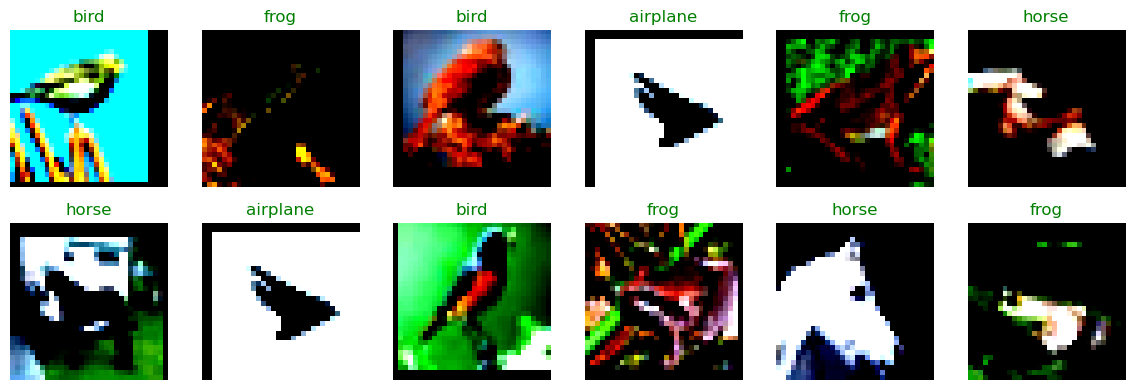

In [374]:
# See random images with their labels
# torch.manual_seed(42)  # setting random seed
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(12, 4))
indexes=[]
rows, cols = 2, 6
for i in range(1, (rows * cols) + 1):
    random_idx = torch.randint(0, len(x_batch), size=[1]).item()
    img, label_gt = x_batch[random_idx], y_batch[random_idx]
    indexes.append(random_idx)
    img_temp = img.unsqueeze(dim=0).to(device)
    # print(img.shape)
    label_pred = torch.argmax(model(img_temp))
    fig.add_subplot(rows, cols, i)
    img = img.permute(1, 2, 0)    # CWH --> WHC
    plt.imshow(img.cpu().numpy(), cmap='gray')
    if label_pred == label_gt:
        plt.title(class_names[label_pred], color='g') # for correct prediction
    else:
        plt.title(class_names[label_pred], color='r') # for incorrect prediction
    plt.axis(False)
    plt.tight_layout();
plt.show()

In [376]:
gc.collect()
torch.cuda.empty_cache()

x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [378]:
# Applying explanation methods on the model outputs
a_batch_integrad = IntegratedGradients(model).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy()
a_batch_integrad[a_batch_integrad<0] = 0
a_batch_saliency = Saliency(model).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()
saliency = Saliency(model)
a_batch_smoothgrad = NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy()
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

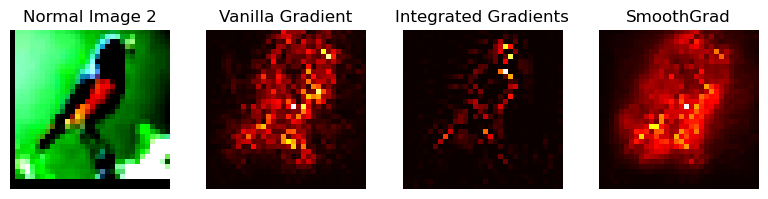

In [379]:
index = indexes[8]
image_explanation(index, x_batch, y_batch, a_batch_saliency, a_batch_integrad, a_batch_smoothgrad, 'vgg_normal')

# Adversarial Training VGG

In [435]:
from pathlib import Path

model_path = Path("models")
model_path.mkdir(parents=True, exist_ok=True)

model_name = "vgg_cifar_adv.pth"
model_save_path = model_path / model_name
model_adv = vgg16().to(device)
model_adv.load_state_dict(torch.load(model_save_path))

<All keys matched successfully>

In [436]:
# Model to GPU and eval mode.
model_adv.to(device)
model_adv.eval()

# Check test set performance.
predictions, labels = evaluate_model(model_adv, test_dataloader, device)
test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())        
print(f"Test accuracy for VGG Adversarial is: {(100 * test_acc):.2f}%")

Test accuracy for VGG Adversarial is: 86.66%


In [115]:
gc.collect()
torch.cuda.empty_cache()

x_batch, y_batch = torch.from_numpy(x_batch), torch.from_numpy(y_batch)
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [118]:
# Applying explanation methods on the model outputs
a_batch_integrad_adv = quantus.normalise_func.normalise_by_negative(IntegratedGradients(model_adv).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy())
a_batch_integrad_adv[a_batch_integrad_adv<0] = 0
a_batch_saliency_adv = quantus.normalise_func.normalise_by_negative(Saliency(model_adv).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy())
saliency = Saliency(model_adv)
a_batch_smoothgrad_adv = quantus.normalise_func.normalise_by_negative(NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy())
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3060222].


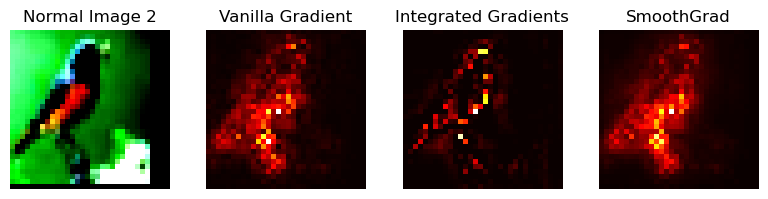

In [123]:
image_explanation(index, x_batch, y_batch, a_batch_saliency_adv, a_batch_integrad_adv, a_batch_smoothgrad_adv, 'vgg_adversarial')

# Pruning L1 Unstructured VGG

In [437]:
from pathlib import Path

model_path = Path("models")
model_path.mkdir(parents=True, exist_ok=True)

model_name = "vgg_cifar_l1_unstructured.pth"
model_save_path = model_path / model_name
model_l1_unstructured = vgg16().to(device)

for name, module in model_l1_unstructured.named_modules():
    # prune 20% of weights/connections in for all hidden layaers-
    if isinstance(module, torch.nn.Conv2d):
        prune.l1_unstructured(module = module, name = 'weight', amount = 0.2)
    
    # prune 10% of weights/connections for output layer-
    elif isinstance(module, torch.nn.Linear):
        prune.l1_unstructured(module = module, name = 'weight', amount = 0.1)

print(f"VGG global sparsity = {compute_sparsity_vgg(model_l1_unstructured):.2f}%")
model_l1_unstructured.load_state_dict(torch.load(model_save_path))

VGG global sparsity = 19.65%


<All keys matched successfully>

In [438]:
# Model to GPU and eval mode.
model_l1_unstructured.to(device)
model_l1_unstructured.eval()

# Check test set performance.
predictions, labels = evaluate_model(model_l1_unstructured, test_dataloader, device)
test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())        
print(f"Test accuracy for VGG Pruned L1 UnStructure is: {(100 * test_acc):.2f}%")

Test accuracy for VGG Pruned L1 UnStructure is: 86.57%


In [133]:
gc.collect()
torch.cuda.empty_cache()
# x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = torch.from_numpy(x_batch), torch.from_numpy(y_batch)
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [134]:
# Applying explanation methods on the model outputs
a_batch_integrad_l1 = IntegratedGradients(model_l1_unstructured).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy()
a_batch_integrad_l1[a_batch_integrad_l1<0] = 0
a_batch_saliency_l1 = Saliency(model_l1_unstructured).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()
saliency = Saliency(model_l1_unstructured)
a_batch_smoothgrad_l1 = NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy()
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3060222].


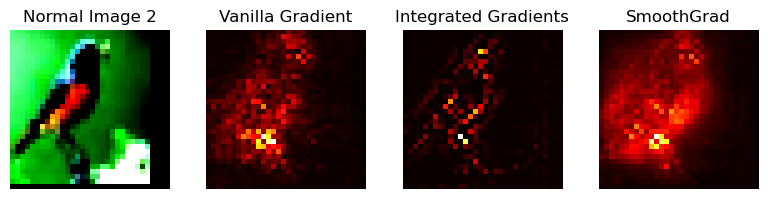

In [137]:
image_explanation(index, x_batch, y_batch, a_batch_saliency_l1, a_batch_integrad_l1, a_batch_smoothgrad_l1, 'vgg_l1_unstructured')

# Global Pruned VGG

In [439]:
from pathlib import Path

prune_rates_global = [0.2, 0.3, 0.4, 0.5, 0.6]

model_path = Path("models")
model_path.mkdir(parents=True, exist_ok=True)

model_name = "vgg_cifar_global.pth"
model_save_path = model_path / model_name
model_global = vgg16().to(device)

parameters_to_prune = (
    (model_global.features[0], 'weight'),
    (model_global.features[2], 'weight'),
    (model_global.features[5], 'weight'),
    (model_global.features[7], 'weight'),
    (model_global.features[10], 'weight'),
    (model_global.features[12], 'weight'),
    (model_global.features[14], 'weight'),
    (model_global.features[17], 'weight'),
    (model_global.features[19], 'weight'),
    (model_global.features[21], 'weight'),
    (model_global.features[24], 'weight'),
    (model_global.features[26], 'weight'),
    (model_global.features[28], 'weight'),
    (model_global.classifier[1], 'weight'),
    (model_global.classifier[4], 'weight'),
    (model_global.classifier[6], 'weight')
)

for iter_prune_round in range(1):
    print(f"\n\nIterative Global pruning round = {iter_prune_round + 1}")
    
    # Prune layer-wise in a structured manner-
    prune.global_unstructured(
        parameters_to_prune,
        pruning_method = prune.L1Unstructured,
        amount = prune_rates_global[iter_prune_round]
        
    )

    # Print current global sparsity level-
    print(f"VGG global sparsity = {compute_sparsity_vgg(model_global):.2f}%")

        
model_global.load_state_dict(torch.load(model_save_path))



Iterative Global pruning round = 1
VGG global sparsity = 20.00%


<All keys matched successfully>

In [440]:
# Model to GPU and eval mode.
model_global.to(device)
model_global.eval()

# Check test set performance.
predictions, labels = evaluate_model(model_global, test_dataloader, device)
test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())        
print(f"Test accuracy for VGG Pruned Global is: {(100 * test_acc):.2f}%")

Test accuracy for VGG Pruned Global is: 83.46%


In [142]:
gc.collect()
torch.cuda.empty_cache()
# x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = torch.from_numpy(x_batch), torch.from_numpy(y_batch)
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [144]:
# Applying explanation methods on the model outputs
a_batch_integrad_global = IntegratedGradients(model_global).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy()
a_batch_integrad_global[a_batch_integrad_global<0] = 0
a_batch_saliency_global =Saliency(model_global).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()
saliency = Saliency(model_global)
a_batch_smoothgrad_global = NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy()

x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3060222].


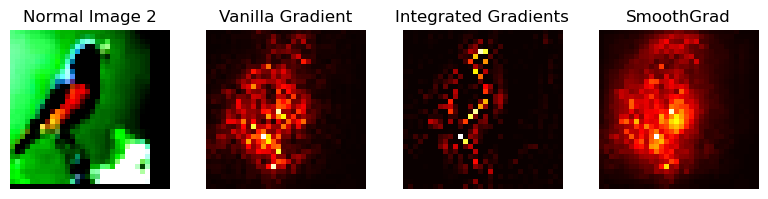

In [145]:
image_explanation(index, x_batch, y_batch, a_batch_saliency_global, a_batch_integrad_global, a_batch_smoothgrad_global, 'vgg_global')

# Pruning Layered Structured VGG

In [441]:
from pathlib import Path

model_path = Path("models")
model_path.mkdir(parents=True, exist_ok=True)

model_name = "vgg_cifar_structured.pth"
model_save_path = model_path / model_name
model_structured = vgg16().to(device)

# # Prune layer-wise in a structured manner-
prune.ln_structured(model_structured.features[0], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.features[2], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.features[5], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.features[7], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.features[10], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.features[12], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.features[14], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.features[17], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.features[19], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.features[21], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.features[24], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.features[26], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.features[28], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.classifier[1], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.classifier[4], name = "weight", amount = 0.1, n = 2, dim = 0)
prune.ln_structured(model_structured.classifier[6], name = "weight", amount = 0.1, n = 2, dim = 0)

# Print current global sparsity level-
print(f"VGG global sparsity = {compute_sparsity_vgg(model_structured):.2f}%")

model_structured.load_state_dict(torch.load(model_save_path))


VGG global sparsity = 9.98%


<All keys matched successfully>

In [442]:
new_params = count_params(model_structured)
print(f"Pruned VGG model has {new_params} trainable parameters")

Pruned VGG model has 15244708 trainable parameters


In [443]:
# Model to GPU and eval mode.
model_structured.to(device)
model_structured.eval()

# Check test set performance.
predictions, labels = evaluate_model(model_structured, test_dataloader, device)
test_acc = np.mean(np.argmax(predictions.cpu().numpy(), axis=1) == labels.cpu().numpy())        
print(f"Test accuracy for VGG Pruned Layered Structure is: {(100 * test_acc):.2f}%")

Test accuracy for VGG Pruned Layered Structure is: 86.17%


In [148]:
gc.collect()
torch.cuda.empty_cache()
# x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = torch.from_numpy(x_batch), torch.from_numpy(y_batch)
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [149]:
# Applying explanation methods on the model outputs
a_batch_integrad_structured = IntegratedGradients(model_structured).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy()
a_batch_integrad_structured[a_batch_integrad_structured<0] = 0
a_batch_saliency_structured = Saliency(model_structured).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy()
saliency = Saliency(model_structured)
a_batch_smoothgrad_structured = NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy()

x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.3060222].


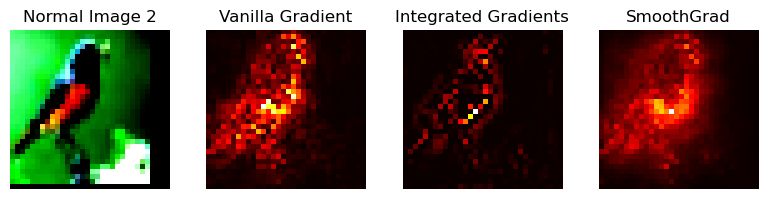

In [155]:
image_explanation(index, x_batch, y_batch, a_batch_saliency_structured, a_batch_integrad_structured, a_batch_smoothgrad_structured, 'vgg_layered_structure')

# Quantitative Metrics Explanation

In [466]:
def explainer_wrapper(**kwargs):
    """
    A wrapper function to call the appropriate explanation method.

    """
    if kwargs["method"] == "SmoothGrad":
        return smoothgrad_explainer(**kwargs)
    else:
        return ValueError("Explanation function doesnt exist")



def smoothgrad_explainer(model, inputs, targets, abs=True, normalise=True, stdevs=0.15, nt_samples=10, *args, **kwargs):
    """
    Generate explanations for a model's predictions using the SmoothGrad method.

    Args:
        model: The model to explain.
        inputs : Input samples.
        targets: Target labels corresponding to the inputs.
        abs : Whether to use the absolute value of gradients.
        normalise: Whether to normalize the explanation
        stdevs: Standard deviation of the noise added to inputs
        nt_samples: Number of noisy samples to generate for SmoothGrad.

    Returns:
        numpy.ndarray: Explanation maps for the input samples.
    """
    std = kwargs.get("std", 0.15)  # Standard deviation for input noise
    n = kwargs.get("n", 10)  # Number of noisy samples
    clip = kwargs.get("clip", False)

    model.to(kwargs.get("device", None))
    model.eval()

    if not isinstance(inputs, torch.Tensor):
        inputs = (
            torch.Tensor(inputs).reshape(-1,kwargs.get("nr_channels", 3),kwargs.get("img_size", 32),kwargs.get("img_size", 32),).to(kwargs.get("device", None))
        )
    
    if not isinstance(targets, torch.Tensor):
        targets = torch.as_tensor(targets).long().to(kwargs.get("device", None))

    assert (len(np.shape(inputs)) == 4), "Inputs should be shaped (nr_samples, nr_channels, img_size, img_size"

    if inputs.shape[0] > 1:
        explanation = torch.zeros(
            (
                n,
                inputs.shape[0],
                kwargs.get("img_size", 32),
                kwargs.get("img_size", 32),
            )
        )
    else:
        explanation = torch.zeros(
            (n, kwargs.get("img_size", 32), kwargs.get("img_size", 32))
        )
    saliency = Saliency(model)
    
    explanation = (
        NoiseTunnel(saliency)
        .attribute(inputs=inputs, target=targets, nt_type="smoothgrad", stdevs = stdevs, nt_samples= 10)
        .sum(axis=1)
        .reshape(-1, kwargs.get("img_size", 32), kwargs.get("img_size", 32))
        .cpu()
        .data
    )

    # explanation = explanation.mean(axis=0)
    gc.collect()
    torch.cuda.empty_cache()

    explanation = explanation.numpy()
    # Normalization (if required)
    if normalise:
        explanation = quantus.normalise_func.normalise_by_negative(explanation)

    # Convert the result to NumPy if it is still a PyTorch tensor
    if isinstance(explanation, torch.Tensor):
        if explanation.requires_grad:
            return explanation.cpu().detach().numpy()
        return explanation.cpu().numpy()

    return explanation

In [160]:
xai_method=["SmoothGrad"]

In [162]:
gc.collect()
torch.cuda.empty_cache()

# ROAD VANILLA GRADIENT

In [99]:
result_normal = filter_and_compute_road(model, test_dataloader, "Saliency", device, resnet = False)

In [100]:
result_adv = filter_and_compute_road(model_adv, test_dataloader,"Saliency", device, resnet = False)

In [101]:
result_l1 = filter_and_compute_road(model_l1_unstructured, test_dataloader,"Saliency", device, resnet = False)

In [102]:
result_global = filter_and_compute_road(model_global, test_dataloader,"Saliency", device, resnet = False)

In [103]:
result_structured = filter_and_compute_road(model_structured, test_dataloader,"Saliency", device, resnet = False)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Plot setup
fig, ax = plt.subplots(figsize=(4, 3))

ax.plot(list(result_normal.keys()),list(result_normal.values()), label='Natural', linestyle='-', marker='o', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_adv.values()), label='Adversarial', linestyle='--', marker='s', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_l1.values()), label='L1 Unstructured', linestyle='--', marker='^', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_global.values()), label='Global Pruned', linestyle='--', marker='v', linewidth=2)
ax.plot(list(result_normal.keys()), list(result_structured.values()), label='Layered Structured', linestyle='--', marker='D', linewidth=2)

# Customize the plot
ax.set_xlabel('% of Features Removed', fontsize=10)
ax.set_ylabel('Accuracy', fontsize=10)
ax.legend(fontsize=10)

# Grid and ticks
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.tick_params(axis='both', which='major', labelsize=10)

plt.savefig("roadplots/VGG_CIFAR_SALIENCY_ROAD.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()

In [102]:
gc.collect()
torch.cuda.empty_cache()

# ROAD INTEGRATED GRADIENTS

In [104]:
result_normal_ig = filter_and_compute_road(model, test_dataloader,"IntegratedGradients", device, resnet = False)

In [105]:
result_adv_ig = filter_and_compute_road(model_adv, test_dataloader,"IntegratedGradients", device, resnet = False)

In [119]:
result_l1_ig = filter_and_compute_road(model_l1_unstructured, test_dataloader,"IntegratedGradients", device, resnet = False)

In [106]:
result_global_ig = filter_and_compute_road(model_global, test_dataloader,"IntegratedGradients", device, resnet = False)

In [121]:
result_structured_ig = filter_and_compute_road(model_structured, test_dataloader,"IntegratedGradients", device, resnet = False)

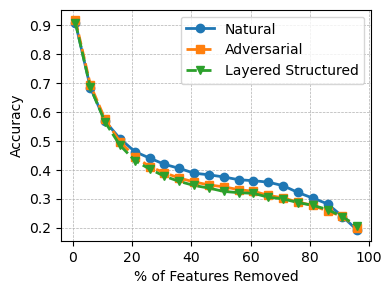

In [112]:
import matplotlib.pyplot as plt
import pandas as pd

# Plot setup
fig, ax = plt.subplots(figsize=(4, 3))

ax.plot(list(result_normal_ig.keys()),list(result_normal_ig.values()), label='Natural', linestyle='-', marker='o', linewidth=2)
ax.plot(list(result_normal_ig.keys()), list(result_adv_ig.values()), label='Adversarial', linestyle='--', marker='s', linewidth=2)
ax.plot(list(result_normal_ig.keys()), list(result_l1_ig.values()), label='L1 Unstructured', linestyle='--', marker='^', linewidth=2)
ax.plot(list(result_normal_ig.keys()), list(result_global_ig.values()), label='Global Pruned', linestyle='--', marker='v', linewidth=2)
ax.plot(list(result_normal_ig.keys()), list(result_structured_ig.values()), label='Layered Structured', linestyle='--', marker='D', linewidth=2)

# Customize the plot
ax.set_xlabel('% of Features Removed', fontsize=10)
ax.set_ylabel('Accuracy', fontsize=10)
ax.legend(fontsize=10)

# Grid and ticks
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.tick_params(axis='both', which='major', labelsize=10)

plt.savefig("roadplots/VGG_CIFAR_IG_ROAD.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()

# ROAD SMOOTHGRAD

In [131]:
gc.collect()
torch.cuda.empty_cache()

In [133]:
result_normal_smooth = filter_and_compute_road(model, test_dataloader, "SmoothGrad", device, resnet = False)

In [134]:
result_adv_smooth = filter_and_compute_road(model_adv, test_dataloader,"SmoothGrad",  device, resnet = False)

In [135]:
result_l1_smooth = filter_and_compute_road(model_l1_unstructured, test_dataloader,"SmoothGrad",  device, resnet = False)

In [136]:
result_global_smooth = filter_and_compute_road(model_global, test_dataloader,"SmoothGrad",  device, resnet = False)

In [137]:
result_structured_smooth = filter_and_compute_road(model_structured, test_dataloader,"SmoothGrad",  device, resnet = False)

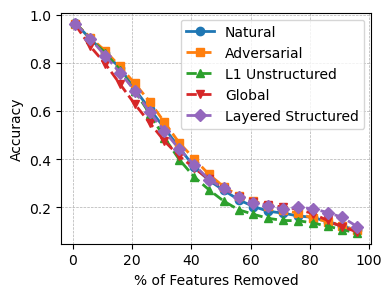

In [138]:
import matplotlib.pyplot as plt
import pandas as pd

# Plot setup
fig, ax = plt.subplots(figsize=(4, 3))

ax.plot(list(result_normal_smooth.keys()),list(result_normal_smooth.values()), label='Natural', linestyle='-', marker='o', linewidth=2)
ax.plot(list(result_normal_smooth.keys()), list(result_adv_smooth.values()), label='Adversarial', linestyle='--', marker='s', linewidth=2)
ax.plot(list(result_normal_smooth.keys()), list(result_l1_smooth.values()), label='L1 Unstructured', linestyle='--', marker='^', linewidth=2)
ax.plot(list(result_normal_smooth.keys()), list(result_global_smooth.values()), label='Global', linestyle='--', marker='v', linewidth=2)
ax.plot(list(result_normal_smooth.keys()), list(result_structured_smooth.values()), label='Layered Structured', linestyle='--', marker='D', linewidth=2)

# Customize the plot
ax.set_xlabel('% of Features Removed', fontsize=10)
ax.set_ylabel('Accuracy', fontsize=10)
ax.legend(fontsize=10)

# Grid and ticks
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.tick_params(axis='both', which='major', labelsize=10)

plt.savefig("roadplots/VGG_CIFAR_SMOOTH_ROAD.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()

# INPUT STABILITY VANILLA GRADIENT

In [147]:
gc.collect()
torch.cuda.empty_cache()

In [149]:
normal_input_saliency = filter_and_compute_input_stability(model, test_dataloader,"Saliency", device, resnet = False)
print("The relative input stability score is: ", normal_input_saliency)

The relative input stability score is:  0.006020467109046703


In [150]:
adversarial_input_saliency = filter_and_compute_input_stability(model_adv, test_dataloader,"Saliency", device, resnet = False)
print("The relative input stability score is: ", adversarial_input_saliency)

The relative input stability score is:  -0.19088814335252208


In [151]:
l1_input_saliency =  filter_and_compute_input_stability(model_l1_unstructured, test_dataloader,"Saliency", device, resnet = False)
print("The relative input stability score is: ", l1_input_saliency)

The relative input stability score is:  0.017227563205190668


In [152]:
global_input_saliency = filter_and_compute_input_stability(model_global, test_dataloader,"Saliency", device, resnet = False)
print("The relative input stability score is: ", global_input_saliency)

The relative input stability score is:  -0.056781665336414204


In [153]:
layered_input_saliency = filter_and_compute_input_stability(model_structured, test_dataloader,"Saliency", device, resnet = False)
print("The relative input stability score is: ", layered_input_saliency)

The relative input stability score is:  -0.09984659905272394


# INPUT STABILITY INTEGRATED GRADIENTS

In [154]:
gc.collect()
torch.cuda.empty_cache()

In [155]:
normal_input_ig  = filter_and_compute_input_stability(model, test_dataloader,"IntegratedGradients", device, resnet = False)
print("The relative input stability score is: ", normal_input_ig)

The relative input stability score is:  2.08685847840643


In [156]:
adversarial_input_ig = filter_and_compute_input_stability(model_adv, test_dataloader,"IntegratedGradients", device, resnet = False)
print("The relative input stability score is: ", adversarial_input_ig)

The relative input stability score is:  1.8853065110077558


In [157]:
l1_input_ig = filter_and_compute_input_stability(model_l1_unstructured, test_dataloader,"IntegratedGradients", device, resnet = False)
print("The relative input stability score is: ",l1_input_ig)

The relative input stability score is:  2.0145407055629363


In [158]:
global_input_ig = filter_and_compute_input_stability(model_global, test_dataloader,"IntegratedGradients", device, resnet = False)
print("The relative input stability score is: ", global_input_ig)

The relative input stability score is:  1.961932222014994


In [159]:
layered_input_ig = filter_and_compute_input_stability(model_structured, test_dataloader,"IntegratedGradients", device, resnet = False)
print("The relative input stability score is: ", layered_input_ig)

The relative input stability score is:  1.9071354460887682


# INPUT STABILITY SMOOTHGRAD

In [161]:
gc.collect()
torch.cuda.empty_cache()

In [162]:
normal_input_smooth  =  filter_and_compute_input_stability(model, test_dataloader, "SmoothGrad", device, resnet = False)
print("The relative input stability score is: ",normal_input_smooth)

The relative input stability score is:  -0.7508587902741357


In [163]:
adversarial_input_smooth =  filter_and_compute_input_stability(model_adv, test_dataloader,"SmoothGrad", device, resnet = False)
print("The relative input stability score is: ",adversarial_input_smooth)

The relative input stability score is:  -0.7955984504536504


In [164]:
l1_input_smooth = filter_and_compute_input_stability(model_l1_unstructured, test_dataloader,"SmoothGrad", device, resnet = False)
print("The relative input stability score is: ", l1_input_smooth)

The relative input stability score is:  -0.7299970622654672


In [165]:
global_input_smooth = filter_and_compute_input_stability(model_global, test_dataloader,"SmoothGrad", device, resnet = False)
print("The relative input stability score is: ", global_input_smooth)

The relative input stability score is:  -0.7369637482492642


In [166]:
layered_input_smooth = filter_and_compute_input_stability(model_structured, test_dataloader,"SmoothGrad", device, resnet = False)
print("The relative input stability score is: ", layered_input_smooth)

The relative input stability score is:  -0.7939018952691962


In [167]:
vanilla_gradient = [normal_input_saliency, adversarial_input_saliency, l1_input_saliency, global_input_saliency, layered_input_saliency]
integrated_gradients = [normal_input_ig, adversarial_input_ig, l1_input_ig, global_input_ig, layered_input_ig]
smoothgrad = [normal_input_smooth, adversarial_input_smooth, l1_input_smooth, global_input_smooth, layered_input_smooth]

row_labels = ["Normal Model", "Adversarial Model", "L1 Unstructured Pruned", "Global Pruned", "Layered Structured Pruned"]

data = {
    "Vanilla Gradient": vanilla_gradient,
    "Integrated Gradients": integrated_gradients,
    "SmoothGrad": smoothgrad
}

df = pd.DataFrame(data, index = row_labels)

df.style.set_table_styles(
    [{'selector': 'th, td', 'props': [('border', '1px solid black')]}]
)

,Vanilla Gradient,Integrated Gradients,SmoothGrad
Normal Model,0.006020,2.086858,-0.750859
Adversarial Model,-0.190888,1.885307,-0.795598
L1 Unstructured Pruned,0.017228,2.014541,-0.729997
Global Pruned,-0.056782,1.961932,-0.736964
Layered Structured Pruned,-0.099847,1.907135,-0.793902


# OUTPUT STABILITY VANILLA GRADIENT

In [185]:
gc.collect()
torch.cuda.empty_cache()

In [186]:
normal_output_saliency = filter_and_compute_output_stability(model, test_dataloader,"Saliency", device, resnet = False)
print("The relative output stability score is: ", normal_output_saliency)

The relative output stability score is:  2.62351541595986


In [187]:
adversarial_output_saliency = filter_and_compute_output_stability(model_adv, test_dataloader,"Saliency", device, resnet = False)
print("The relative output stability score is: ", adversarial_output_saliency)

The relative output stability score is:  2.8192255128034915


In [188]:
l1_output_saliency = filter_and_compute_output_stability(model_l1_unstructured, test_dataloader,"Saliency", device, resnet = False)
print("The relative output stability score is: ", l1_output_saliency)

The relative output stability score is:  2.662823571449896


In [189]:
global_output_saliency = filter_and_compute_output_stability(model_global, test_dataloader,"Saliency", device, resnet = False)
print("The relative output stability score is: ", global_output_saliency)

The relative output stability score is:  2.600214317912361


In [190]:
layered_output_saliency = filter_and_compute_output_stability(model_structured, test_dataloader,"Saliency", device, resnet = False)
print("The relative output stability score is: ",layered_output_saliency )

The relative output stability score is:  2.5083992023445467


# OUTPUT STABILITY INTEGRATED GRADIENTS

In [191]:
gc.collect()
torch.cuda.empty_cache()

In [192]:
normal_output_ig = filter_and_compute_output_stability(model, test_dataloader,"IntegratedGradients", device, resnet = False)
print("The relative output stability score is: ", normal_output_ig)

The relative output stability score is:  4.682335632052278


In [193]:
adversarial_output_ig = filter_and_compute_output_stability(model_adv, test_dataloader,"IntegratedGradients", device, resnet = False)
print("The relative output stability score is: ", adversarial_output_ig)

The relative output stability score is:  4.673010975859937


In [194]:
l1_output_ig =  filter_and_compute_output_stability(model_l1_unstructured, test_dataloader,"IntegratedGradients", device, resnet = False)
print("The relative output stability score is: ",l1_output_ig)

The relative output stability score is:  4.56845332206729


In [195]:
global_output_ig = filter_and_compute_output_stability(model_global, test_dataloader,"IntegratedGradients", device, resnet = False)
print("The relative output stability score is: ",global_output_ig )

The relative output stability score is:  4.619938831280848


In [196]:
layered_output_ig = filter_and_compute_output_stability(model_structured, test_dataloader,"IntegratedGradients", device, resnet = False)
print("The relative output stability score is: ", layered_output_ig)

The relative output stability score is:  4.4482123373710305


# OUTPUT STABILITY SMOOTHGRAD

In [198]:
gc.collect()
torch.cuda.empty_cache()

In [199]:
normal_output_smooth =  filter_and_compute_output_stability(model, test_dataloader, "SmoothGrad", device, resnet = False)
print("The relative output stability score is: ",normal_output_smooth)

The relative output stability score is:  1.9232326393815664


In [200]:
adversarial_output_smooth =  filter_and_compute_output_stability(model_adv, test_dataloader, "SmoothGrad", device, resnet = False)
print("The relative output stability score is: ",adversarial_output_smooth)

The relative output stability score is:  2.253182188840668


In [201]:
l1_output_smooth = filter_and_compute_output_stability(model_l1_unstructured, test_dataloader, "SmoothGrad", device, resnet = False)
print("The relative output stability score is: ", l1_output_smooth)

The relative output stability score is:  1.947890604758193


In [202]:
global_output_smooth = filter_and_compute_output_stability(model_global, test_dataloader, "SmoothGrad", device, resnet = False)
print("The relative output stability score is: ", global_output_smooth)

The relative output stability score is:  1.969694682956773


In [203]:
layered_output_smooth = filter_and_compute_output_stability(model_structured, test_dataloader, "SmoothGrad", device, resnet = False)
print("The relative output stability score is: ", layered_output_smooth)

The relative output stability score is:  1.843029696947983


In [204]:
vanilla_gradient = [normal_output_saliency, adversarial_output_saliency, l1_output_saliency, global_output_saliency, layered_output_saliency]
integrated_gradients = [normal_output_ig, adversarial_output_ig, l1_output_ig, global_output_ig, layered_output_ig]
smoothgrad = [normal_output_smooth, adversarial_output_smooth, l1_output_smooth, global_output_smooth, layered_output_smooth]

row_labels = ["Normal Model", "Adversarial Model", "L1 Unstructured Pruned", "Global Pruned", "Layered Structured Pruned"]

data = {
    "Vanilla Gradient": vanilla_gradient,
    "Integrated Gradients": integrated_gradients,
    "SmoothGrad": smoothgrad
}

df = pd.DataFrame(data, index = row_labels)

df.style.set_table_styles(
    [{'selector': 'th, td', 'props': [('border', '1px solid black')]}]
)

,Vanilla Gradient,Integrated Gradients,SmoothGrad
Normal Model,2.623515,4.682336,1.923233
Adversarial Model,2.819226,4.673011,2.253182
L1 Unstructured Pruned,2.662824,4.568453,1.947891
Global Pruned,2.600214,4.619939,1.969695
Layered Structured Pruned,2.508399,4.448212,1.843030


# SPARSITY VANILLA GRADIENT

In [206]:
gc.collect()
torch.cuda.empty_cache()

In [207]:
normal_sparse_saliency = filter_and_compute_sparsity(model, test_dataloader,"Saliency", device, resnet = False)
print("The sparsity score is: ", normal_sparse_saliency)

The sparsity score is:  (0.5726994638395948, 0.004584305892854839)


In [208]:
adversarial_sparse_saliency = filter_and_compute_sparsity(model_adv, test_dataloader,"Saliency", device, resnet = False)
print("The sparsity score is: ", adversarial_sparse_saliency)

The sparsity score is:  (0.5972986099098042, 0.004904099955738187)


In [209]:
l1_sparse_saliency =  filter_and_compute_sparsity(model_l1_unstructured, test_dataloader,"Saliency", device, resnet = False)
print("The sparsity score is: ",l1_sparse_saliency)

The sparsity score is:  (0.5738094976392467, 0.005116665733681111)


In [210]:
global_sparse_saliency = filter_and_compute_sparsity(model_global, test_dataloader,"Saliency", device, resnet = False)
print("The sparsity score is: ", global_sparse_saliency)

The sparsity score is:  (0.5624702731796459, 0.005317814904009483)


In [211]:
layered_sparse_saliency = filter_and_compute_sparsity(model_structured, test_dataloader,"Saliency", device, resnet = False)
print("The sparsity score is: ",layered_sparse_saliency  )

The sparsity score is:  (0.5122827342001331, 0.017010550552633678)


# SPARSITY INTEGRATED GRADIENT

In [212]:
gc.collect()
torch.cuda.empty_cache()

In [213]:
normal_sparse_ig =  filter_and_compute_sparsity(model, test_dataloader,"IntegratedGradients", device, resnet = False)
print("The sparsity score is: ",normal_sparse_ig)

The sparsity score is:  (0.6501560334004735, 0.0038958996317912387)


In [214]:
adversarial_sparse_ig = filter_and_compute_sparsity(model_adv, test_dataloader,"IntegratedGradients", device, resnet = False)
print("The sparsity score is: ",adversarial_sparse_ig )

The sparsity score is:  (0.6719259052821809, 0.004295748463367508)


In [215]:
l1_sparse_ig = filter_and_compute_sparsity(model_l1_unstructured, test_dataloader,"IntegratedGradients", device, resnet = False)
print("The sparsity score is: ", l1_sparse_ig)

The sparsity score is:  (0.6560931448904695, 0.004290100112678763)


In [216]:
global_sparse_ig = filter_and_compute_sparsity(model_global, test_dataloader,"IntegratedGradients", device, resnet = False)
print("The sparsity score is: ",global_sparse_ig )

The sparsity score is:  (0.6351893832086976, 0.004785989095752681)


In [217]:
layered_sparse_ig = filter_and_compute_sparsity(model_structured, test_dataloader,"IntegratedGradients", device, resnet = False)
print("The sparsity score is: ", layered_sparse_ig)

The sparsity score is:  (0.5758098355768306, 0.019984059895344727)


# SPARSITY SMOOTHGRAD

In [219]:
gc.collect()
torch.cuda.empty_cache()

In [220]:
normal_sparse_smooth = filter_and_compute_sparsity(model, test_dataloader,"SmoothGrad", device, resnet = False)
print("The sparsity score is: ",normal_sparse_smooth )

The sparsity score is:  (0.4657412467932185, 0.005326518347014147)


In [221]:
adversarial_sparse_smooth = filter_and_compute_sparsity(model_adv, test_dataloader,"SmoothGrad", device, resnet = False)
print("The sparsity score is: ", adversarial_sparse_smooth)

The sparsity score is:  (0.5190453759394414, 0.005456594232724554)


In [222]:
l1_sparse_smooth = filter_and_compute_sparsity(model_l1_unstructured, test_dataloader,"SmoothGrad", device, resnet = False)
print("The sparsity score is: ", l1_sparse_smooth)

The sparsity score is:  (0.46498667493850254, 0.005974374413143117)


In [223]:
global_sparse_smooth = filter_and_compute_sparsity(model_global, test_dataloader,"SmoothGrad", device, resnet = False)
print("The sparsity score is: ", global_sparse_smooth)

The sparsity score is:  (0.46332769971628734, 0.006009343492445573)


In [224]:
layered_sparse_smooth =  filter_and_compute_sparsity(model_structured, test_dataloader,"SmoothGrad", device, resnet = False)
print("The sparsity score is: ",layered_sparse_smooth)

The sparsity score is:  (0.4188853146879053, 0.013438792225912263)


In [225]:
vanilla_gradient = [normal_sparse_saliency, adversarial_sparse_saliency, l1_sparse_saliency, global_sparse_saliency, layered_sparse_saliency]
integrated_gradients = [normal_sparse_ig, adversarial_sparse_ig, l1_sparse_ig, global_sparse_ig, layered_sparse_ig]
smoothgrad = [normal_sparse_smooth, adversarial_sparse_smooth, l1_sparse_smooth, global_sparse_smooth, layered_sparse_smooth]

row_labels = ["Normal Model", "Adversarial Model", "L1 Unstructured Pruned", "Global Pruned", "Layered Structured Pruned"]

data = {
    "Vanilla Gradient": vanilla_gradient,
    "Integrated Gradients": integrated_gradients,
    "SmoothGrad": smoothgrad
}

df = pd.DataFrame(data, index = row_labels)

df.style.set_table_styles(
    [{'selector': 'th, td', 'props': [('border', '1px solid black')]}]
)

,Vanilla Gradient,Integrated Gradients,SmoothGrad
Normal Model,"(0.5726994638395948, 0.004584305892854839)","(0.6501560334004735, 0.0038958996317912387)","(0.4657412467932185, 0.005326518347014147)"
Adversarial Model,"(0.5972986099098042, 0.004904099955738187)","(0.6719259052821809, 0.004295748463367508)","(0.5190453759394414, 0.005456594232724554)"
L1 Unstructured Pruned,"(0.5738094976392467, 0.005116665733681111)","(0.6560931448904695, 0.004290100112678763)","(0.46498667493850254, 0.005974374413143117)"
Global Pruned,"(0.5624702731796459, 0.005317814904009483)","(0.6351893832086976, 0.004785989095752681)","(0.46332769971628734, 0.006009343492445573)"
Layered Structured Pruned,"(0.5122827342001331, 0.017010550552633678)","(0.5758098355768306, 0.019984059895344727)","(0.4188853146879053, 0.013438792225912263)"
